## Import Libraries

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.utils as vutils
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

## Set Up Data Augmentation and DataLoader

In [2]:
# Set up data augmentation
transform = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),  # Normalizing the images to [-1, 1]
    ]
)

# Load our dataset
dataset = datasets.ImageFolder(root="./training/images/", transform=transform)

# Create DataLoader
dataloader = DataLoader(
    dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count()
)

## Define the Generator and Discriminator

In [3]:
def show_generated_images(epoch, generator, fixed_noise, num_images=64, img_size=64):
    with torch.no_grad():
        fake_images = generator(fixed_noise).detach().cpu()
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(f"Generated Images at Epoch {epoch}")
    plt.imshow(
        np.transpose(
            vutils.make_grid(fake_images[:num_images], padding=2, normalize=True),
            (1, 2, 0),
        )
    )
    plt.show()

In [4]:
# Generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, input):
        return self.main(input)


# Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)

## Initialize Models, Loss Function, and Optimizers

In [5]:
# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = Generator().to(device)
D = Discriminator().to(device)

# Fixed noise vector for visual consistency
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

# Loss function
criterion = nn.BCELoss()

# Optimizers
lr = 0.0002
beta1 = 0.5
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))

## Training Loop

Epoch [1/5]:   0%|          | 0/47 [01:37<?, ?it/s, D_G_z=0.000123, D_x=0.99, loss_D=0.145, loss_G=9.43]  

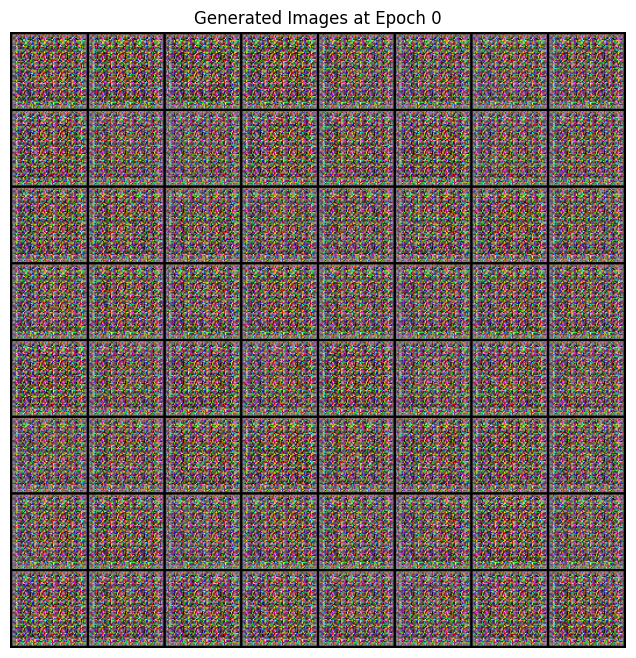

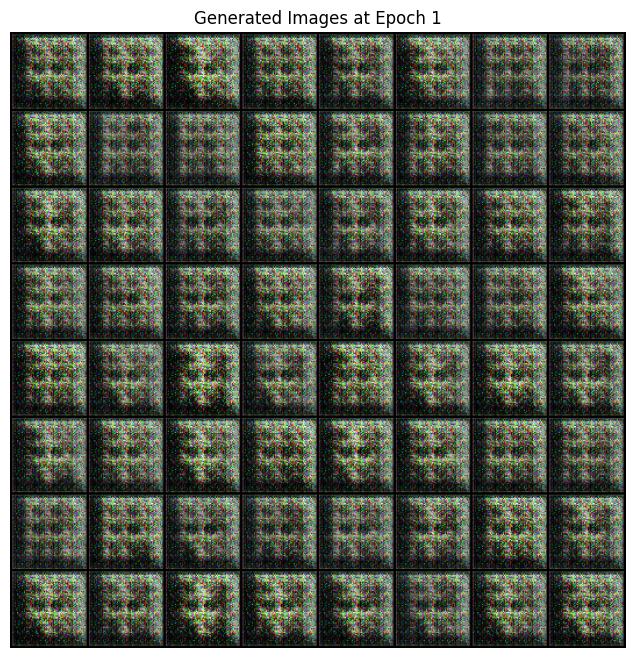

Epoch [3/5]:   0%|          | 0/47 [01:34<?, ?it/s, D_G_z=0.0134, D_x=0.816, loss_D=0.683, loss_G=4.53]  

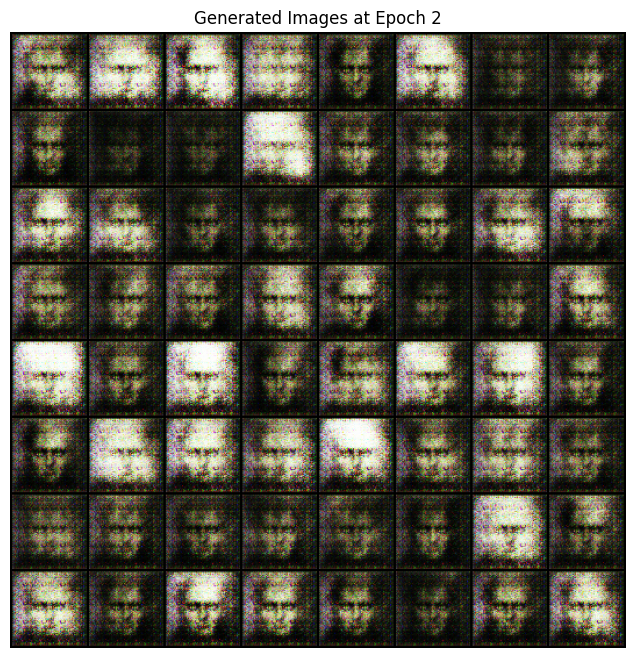

Epoch [5/5]:   0%|          | 0/47 [02:00<?, ?it/s, D_G_z=0.0898, D_x=0.397, loss_D=1.2, loss_G=2.72]    

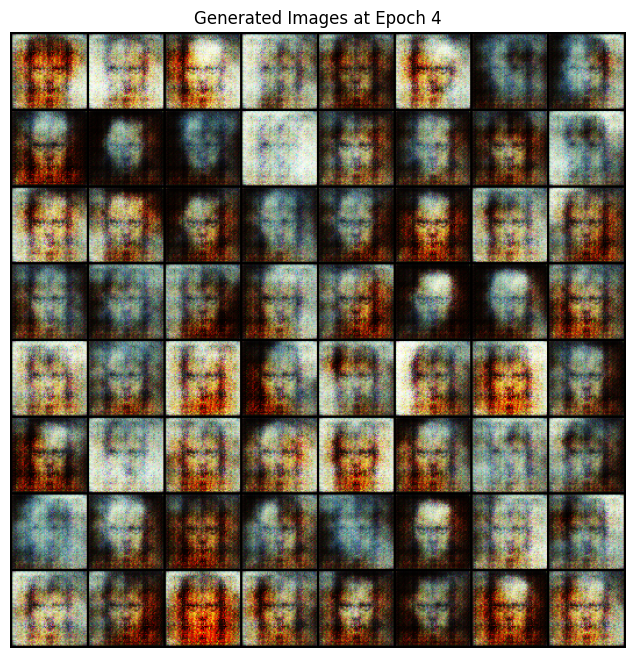

In [6]:
# Create instances of the models
G = Generator().to(device)
D = Discriminator().to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizers
G_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
num_epochs = 5  # Number of epochs. Adjust as needed
loss_D_values, loss_G_values, Dx_values, DGz_values = [], [], [], []
for epoch in range(num_epochs):
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=False)
    for i, (images, _) in enumerate(dataloader):
        # Training the Discriminator
        D.zero_grad()
        real_images = images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size,), 1, dtype=torch.float, device=device)

        output = D(real_images).view(-1)
        loss_real = criterion(output, labels)
        loss_real.backward()
        D_x = output.mean().item()

        # Generate fake images
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake_images = G(noise)
        labels.fill_(0)

        output = D(fake_images.detach()).view(-1)
        loss_fake = criterion(output, labels)
        loss_fake.backward()
        D_G_z1 = output.mean().item()

        loss_D = loss_real + loss_fake
        D_optimizer.step()

        # Training the Generator
        G.zero_grad()
        labels.fill_(1)  # The generator's goal is to fool the discriminator
        output = D(fake_images).view(-1)
        loss_G = criterion(output, labels)
        loss_G.backward()
        D_G_z2 = output.mean().item()
        G_optimizer.step()

        loss_D_values.append(loss_D.item())
        loss_G_values.append(loss_G.item())
        Dx_values.append(D_x)
        DGz_values.append(D_G_z2)

        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(
            loss_D=loss_D.item(), loss_G=loss_G.item(), D_x=D_x, D_G_z=D_G_z2
        )
    show_generated_images(epoch, G, fixed_noise)

    # Optionally, save the models periodically or after training
    # torch.save(G.state_dict(), f'generator_epoch_{epoch}.pth')
    # torch.save(D.state_dict(), f'discriminator_epoch_{epoch}.pth')

### Understanding the stats of our DCGAN model training 

1. **Loss_D (Discriminator Loss)**: This value indicates how well the discriminator is distinguishing between real and fake images. A lower Loss_D suggests better performance. However, if it's too low, it might mean the discriminator is overfitting or the generator is underperforming.

2. **Loss_G (Generator Loss)**: This represents how well the generator is at creating images that the discriminator thinks are real. A lower Loss_G is generally better, indicating that the generator is improving.

3. **D(x)**: This is the average output for the discriminator on real images. Closer to 1 is better, as it means the discriminator is correctly identifying real images as real.

4. **D(G(z))**: This represents the discriminator's output on fake images. The first number (before the slash) is the value at the start of the iteration, and the second number (after the slash) is the value at the end. Ideally, you want the first number to be high (indicating the discriminator initially thinks the fake images are real) and the second number to be low (indicating that after the generator's update, its new images are more easily detected as fake by the discriminator).

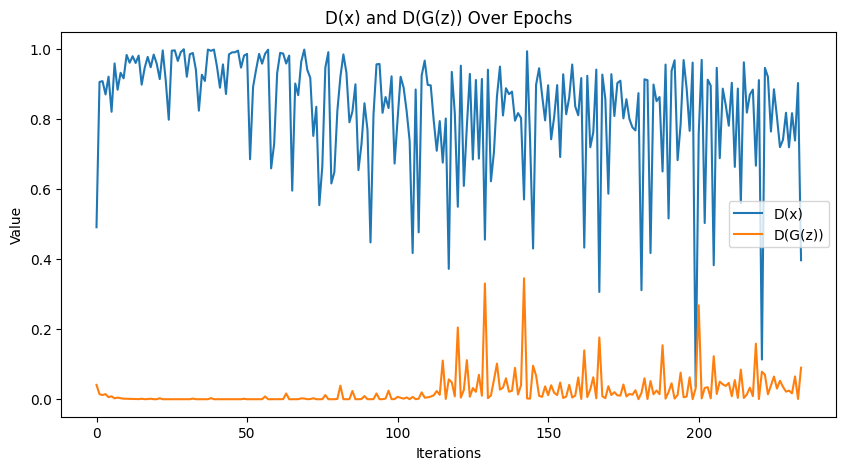

In [7]:
plt.figure(figsize=(10, 5))
plt.title("Loss Over Epochs")
plt.plot(loss_D_values, label="Discriminator Loss")
plt.plot(loss_G_values, label="Generator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.title("D(x) and D(G(z)) Over Epochs")
plt.plot(Dx_values, label="D(x)")
plt.plot(DGz_values, label="D(G(z))")
plt.xlabel("Iterations")
plt.ylabel("Value")
plt.legend()
plt.show()

## Save the Trained Models

In [8]:
torch.save(G.state_dict(), "./models/generator_final.pth")
torch.save(D.state_dict(), "./models/discriminator_final.pth")